<a href="https://colab.research.google.com/github/mcleantom/MultiObjectiveOptimization/blob/main/SimulatedAnnealing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pymoo osmnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 61.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pa

In [3]:
!wget https://raw.githubusercontent.com/SmartMobilityAlgorithms/book/main/content/PeopleMobilityProblems/multicriteriarouting/collision_with_osmnxId.csv

--2023-03-29 20:32:15--  https://raw.githubusercontent.com/SmartMobilityAlgorithms/book/main/content/PeopleMobilityProblems/multicriteriarouting/collision_with_osmnxId.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20656 (20K) [text/plain]
Saving to: ‘collision_with_osmnxId.csv’

collision_with_osmn 100%[===================>]  20.17K  --.-KB/s    in 0.003s  

2023-03-29 20:32:15 (7.17 MB/s) - ‘collision_with_osmnxId.csv’ saved [20656/20656]



In [6]:
import osmnx
import pandas as pd
from collections import *
import numpy as np
from pymoo.core.problem import Problem
import random
from pymoo.core.duplicate import ElementwiseDuplicateElimination
from pymoo.core.mutation import Mutation
from pymoo.core.sampling import Sampling
from pymoo.core.crossover import Crossover
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from matplotlib import pyplot as plt
import osmnx
from tqdm.notebook import tqdm
import tabulate
import itertools
import timeit

In [7]:
df = pd.read_csv("collision_with_osmnxId.csv")
df.head(10)

,Unnamed: 0,LATITUDE,LONGITUDE,Collision,osmnxId
0,0,43.649418,-79.371446,0,4095622247
1,1,43.650461,-79.371924,0,25768773
2,2,43.651534,-79.372360,0,29687658
3,3,43.652718,-79.372824,0,29687912
4,4,43.653704,-79.373238,0,29688544
5,5,43.655357,-79.373862,0,29688418
6,6,43.657052,-79.374531,1,25768772
7,7,43.660432,-79.375854,0,29603394
8,8,43.662420,-79.376708,1,27571559
9,9,43.666289,-79.378325,1,25628755


In [8]:
intersectionData = df.osmnxId.to_list()
collisionData = df.loc[df["Collision"] == 1].osmnxId.to_list()

In [9]:
bbox = [43.647281, 43.669197, -79.411827, -79.374476]
G = osmnx.graph_from_bbox(*bbox, network_type='drive_service')

In [16]:
"""
common stuff for gluing things together and hiding unnecessary complexity 
""" 
from collections import deque
import math
from copy import deepcopy
from itertools import islice
import copy
from multiprocessing import Pool
"""
This is a wrapper around osmnx nodes so we can query a single node
with questions like that without having to deal with networkx dictionaries:
    * how did we get here from the origin?
    * what are my children?
    * what is my unique id
"""

class Node:
    # using __slots__ for optimization
    __slots__ = ['node', 'distance', 'parent', 'osmid', 'G']
    # constructor for each node
    def __init__(self ,graph , osmid, distance = 0, parent = None):
        # the dictionary of each node as in networkx graph --- still needed for internal usage
        self.node = graph[osmid]
        
        # the distance from the parent node --- edge length
        self.distance = distance
        
        # the parent node
        self.parent = parent
        
        # unique identifier for each node so we don't use the dictionary returned from osmnx
        self.osmid = osmid
        
        # the graph
        self.G = graph
    
    # returning all the nodes adjacent to the node
    def expand(self):
        children = [Node(graph = self.G, osmid = child, distance = self.node[child][0]['length'], parent = self) \
                        for child in self.node]
        return children
    
    # returns the path from that node to the origin as a list and the length of that path
    def path(self):
        node = self
        path = []
        while node:
            path.append(node.osmid)
            node = node.parent
        return path[::-1]
    
    # the following two methods are for dictating how comparison works

    def __eq__(self, other):
        try:
            return self.osmid == other.osmid
        except:
            return self.osmid == other
            
    
    def __hash__(self):
        return hash(self.osmid)



def shortest_path_with_failed_nodes_single(G,route,failed:list):
    i = 1
    j = len(route) -2
    result = shortest_path_with_failed_nodes(G,route,i,j,failed)
    if result is math.inf: return result
    path, i,j, r = result
    return r

def shortest_path_with_failed_nodes(G, route ,i,j, failed : list):
    source = route[i-1]
    target = route[j+1]
    origin = Node(graph = G, osmid = source)
    destination = Node(graph = G, osmid = target)

    ## you can't introduce failure in the source and target
    # node, because your problem will lose its meaning
    if source in failed: failed.remove(source)
    if target in failed: failed.remove(target)
    
    # if after removing source/target node from failed
    # list - just return math.inf which is equivalent to failure in search
    if len(failed) == 0: return math.inf

    # we need to flag every node whether it is failed or not
    failure_nodes = {node: False for node in G.nodes()}
    failure_nodes.update({node: True for node in failed})

    # we need to make sure that while expansion we don't expand
    # any node from the original graph to avoid loops in our route
    tabu_list = route[:route.index(source)] \
                + \
                route[route.index(target) + 1:] 

    # the normal implementation of dijkstra
    shortest_dist = {node: math.inf for node in G.nodes()}
    unrelaxed_nodes = [Node(graph = G, osmid = node) for node in G.nodes()]
    seen = set()

    shortest_dist[source] = 0

    while len(unrelaxed_nodes) > 0:
        node = min(unrelaxed_nodes, key = lambda node : shortest_dist[node])

        # if we have relaxed articulation nodes in our graph
        # halt the process -- we have more than one component
        # in our graph which makes the question of shortest path
        # invalid

        if shortest_dist[node.osmid] == math.inf: return math.inf

        if node == destination:
            return node.path(),i,j, route

        unrelaxed_nodes.remove(node); seen.add(node.osmid) # relaxing the node

        for child in node.expand():
            # if it is failed node, skip it
            if failure_nodes[child.osmid] or\
                child.osmid in seen or\
                child.osmid in tabu_list:
                continue

            child_obj = next((node for node in unrelaxed_nodes if node.osmid == child.osmid), None)
            child_obj.distance = child.distance

            distance = shortest_dist[node.osmid] + child.distance
            if distance < shortest_dist[child_obj.osmid]:
                shortest_dist[child_obj.osmid] = distance
                child_obj.parent = node

    # in case the node can't be reached from the origin
    # this return happens when the node is not on the graph
    # at all, if it was on a different component the second
    # return will be executed -- this is the third return
    
    return math.inf


def shortest_path_handler(args):
    return shortest_path_with_failed_nodes(*args)


def children_route(G, route, limit):
    results = []
    for i in range(1, len(route) - 1):
        for j in range(i, len(route) -1):
            # we can't work on the route list directly
            # because lists are passed by reference
            stitched = copy.deepcopy(route)
            failing_nodes = copy.deepcopy(route[i:j+1])
            args = shortest_path_with_failed_nodes(G, stitched, i,j, failing_nodes)
            if args == math.inf: continue
            to_be_stitched, k, l, r = args
            stitched[i:j+1] = to_be_stitched[1:-1]      # we need to skip the first and starting nodes of this route
                                                        # because these nodes already exit
            results.append(stitched)
            if len(results) == limit: return results
    return results

def children_route_handler(args):
    return children_route(*args)


def get_children(G, route, num_children=20, multiprocessing=False, workers=4):
    if multiprocessing:
        worker = ChildRoutesGenerator(workers=workers,G = G, route=route, limit=num_children)
        worker.do_job()
        worker.pool.terminate()
        worker.pool.join()
        return worker.result
    return children_route(G,route,num_children)


class ChildRoutesGenerator():
    def __init__(self, workers, G, route, limit=20):
        self.workers = workers
        self.pool = Pool(processes=self.workers)
        self.result = []
        self.limit = limit
        self.G = G
        self.route = route

    def do_beam(self,routes):
        args = []
        results = []
        for r in routes:
            args.append((self.G,r,self.limit))
        for _ in self.pool.imap_unordered(children_route_handler,args, chunksize=1):
            results.append(_)
        self.pool.terminate()
        self.pool.join()
        return results

    def do_job(self, route=None, refresh=False):
        
        if refresh: self.pool = Pool(processes=self.workers)
        if route is not None:
            self.route = route
        args = []
        
        for i in range(1, len(self.route) - 1):
            for j in range(i, len(self.route) -1):
                stitched = deepcopy(self.route)
                failing_nodes = deepcopy(self.route[i:j+1])
                args.append((self.G, stitched, i, j, failing_nodes))
        
        for _ in self.pool.imap_unordered(shortest_path_handler,args, chunksize=1):
            if _ == math.inf: 
                continue
            new,i,j,old = _
            old[i:j+1] = new[1:-1]
            self.result.append(old)
            if len(self.result) == self.limit:
                break
        self.pool.terminate()
        self.pool.join()
        return self.result

def randomized_search(G, source, destination):
    origin = Node(graph = G, osmid = source)
    destination = Node(graph = G, osmid = destination)
    
    route = [] # the route to be yielded
    frontier = deque([origin])
    explored = set()
    while frontier:
        node = random.choice(frontier)   # here is the randomization part
        frontier.remove(node)
        explored.add(node.osmid)

        for child in node.expand():
            if child not in explored and child not in frontier:
                if child == destination:
                    route = child.path()
                    return route
                frontier.append(child)

    raise Exception("destination and source are not on same component")

def probability(p):
    return p > random.uniform(0.0, 1.0)

In [11]:
origin = Node(G, 82759481)
destination = Node(G, 29605000)

# Simulated Annealing

In [12]:
def exp_schedule(k=20, lam=0.005, limit=100):
  f = lambda t: (k*np.exp(-lam*t) if t < limit else 0)
  return f

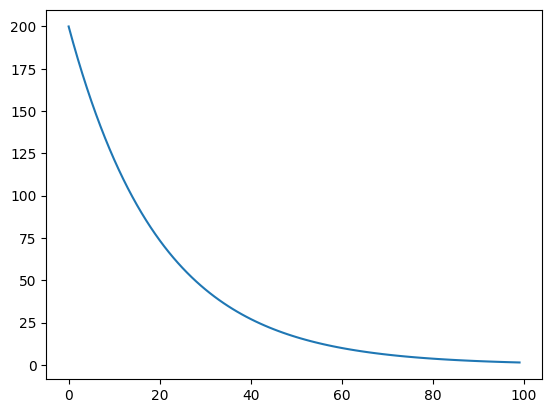

In [13]:
schedule = exp_schedule(200, 0.05, 10000)
T = [schedule(k) for k in range(100)]
plt.plot(T)

# Solution class

In [18]:
def cost(G, route):
  weight = 0
  for u, v in zip(route, route[1:]):
    weight += G[u][v][0]['length']
  return round(weight, 4)

def weightedCost(G, route, weight1, weight2):
  weight = 0
  for u, v in zip(route, route[1:]):
    weight += G[u][v][0]['length']
    if str(v) in intersectionData:
      weight += weight1
    if str(v) in collisionData:
      weight += weight2
  return round(weight, 4)

def distanceCost(G, route):
  weight = 0
  for u, v in zip(route, route[1:]):
    weight += G[u][v][0]['length']
  return round(weight, 4)

def intersectionCost(G, route):
  weight = 0
  for u, v in zip(route, route[1:]):
    if v in intersectionData:
      weight += 1
  return weight

def collisionCost(G, route):
  weight = 0
  for u, v in zip(route, route[1:]):
    if v in collisionData:
      weight += 1
  return weight


def SA(temperature, num_iterations, weight1, weight2):
  schedule = exp_schedule(temperature, 0.05, 10000)
  states = []
  current = randomized_search(G, origin.osmid, destination.osmid)

  for t in tqdm(range(num_iterations)):
    T = schedule(t)
    states.append(weightedCost(G, current, weight1, weight2))

    neighbours = get_children(G, current, num_children=5)
    next_choice = random.choice(neighbours)

    delta_e = weightedCost(G, next_choice, weight1, weight2) - weightedCost(G, current, weight1, weight2)
    if delta_e < 0 or probability(np.exp(-1 * delta_e/T)):
      current  = next_choice
  route = current
  return route, states


def adaptiveSA(temperature, num_iterations, weight1, weight2):
  schedule = exp_schedule(temperature, 0.05, 10000)

  states = []
  current = randomized_search(G, origin.osmid, destination.osmid)

  for t in tqdm(range(num_iterations)):
    T = schedule(t)

    acceptance_P = random.uniform(0, 1)

    states.append(weightedCost(G, current, weight1, weight2))

    neighbours = get_children(G, current, num_children=5)

    next_choice = random.choice(neighbours)

    delta_e = weightedCost(G, next_choice, weight1, weight2) - weightedCost(G, current, weight1, weight2)
    if delta_e < 0 or probability(np.exp(-1 * delta_e/T)) > acceptance_P:
      current = next_choice
  route = current
  return route, states


def singleSA(temperature, num_iterations, weight1, weight2):
  schedule = exp_schedule(temperature, 0.05, 10000)
  states = []
  current = randomized_search(G, origin.osmid, destination.osmid)

  for t in tqdm(range(num_iterations)):
    T = schedule(t)
    states.append(cost(G, current))

    neighbours = get_children(G, current, num_children=5)
    next_choice = random.choice(neighbours)

    delta_e = cost(G, next_choice) - cost(G, current)

    if delta_e < 0 or probability(np.exp(-1 * delta_e/T)):
      current = next_choice
  
  route = current
  return route, states


def getResult(resultRoute):
  return {
      "len": len(resultRoute),
      "route": resultRoute,
      "distance": distanceCost(G, resultRoute),
      "intersections": intersectionCost(G, resultRoute),
      "collisions": collisionCost(G, resultRoute)
  }


def printResult(resultRoute):
    print(len(resultRoute))
    print(resultRoute)
    print("distance: ", distanceCost(G, resultRoute))
    print("intersections: ", intersectionCost(G, resultRoute))
    print("collisions: ", collisionCost(G, resultRoute))

def printStates(resultStates):
    minValue = float('inf')
    minIndex = -1
    for i,v in enumerate(resultStates):
      if v < minValue:
        minValue = v
        minIndex = i
    
    print("convergence iteration number: ", minIndex)

    plt.xlabel("# iterations")
    plt.ylabel("Weighted Cost (meters)")
    plt.plot(resultStates)
    plt.show()

In [19]:
temperature = 225
num_iterations = 80
weight1 = 50
weight2 = 200
route1,states1 = SA(temperature, num_iterations, weight1, weight2)

  0%|          | 0/80 [00:00<?, ?it/s]

In [20]:
route1 = getResult(route1)
headers = ['starting_temp'] + list(route1.keys())
t1 = [225] + list(route1.values())
table = [headers,t1]
routes = [x[2] for x in table[1:]]
table = [[x[0]]+x[3:] for x in table]
print(tabulate.tabulate(table, tablefmt='fancy_grid'))

╒═══════════════╤══════════╤═══════════════╤════════════╕
│ starting_temp │ distance │ intersections │ collisions │
├───────────────┼──────────┼───────────────┼────────────┤
│ 225           │ 1809.877 │ 3             │ 0          │
╘═══════════════╧══════════╧═══════════════╧════════════╛


In [22]:
route_map = osmnx.plot_route_folium(G,routes[0], color="green",opacity="0.5")
route_map

[Text(0.5, 0, '# iterations'), Text(0, 0.5, 'Weighted Cost (meters)')]

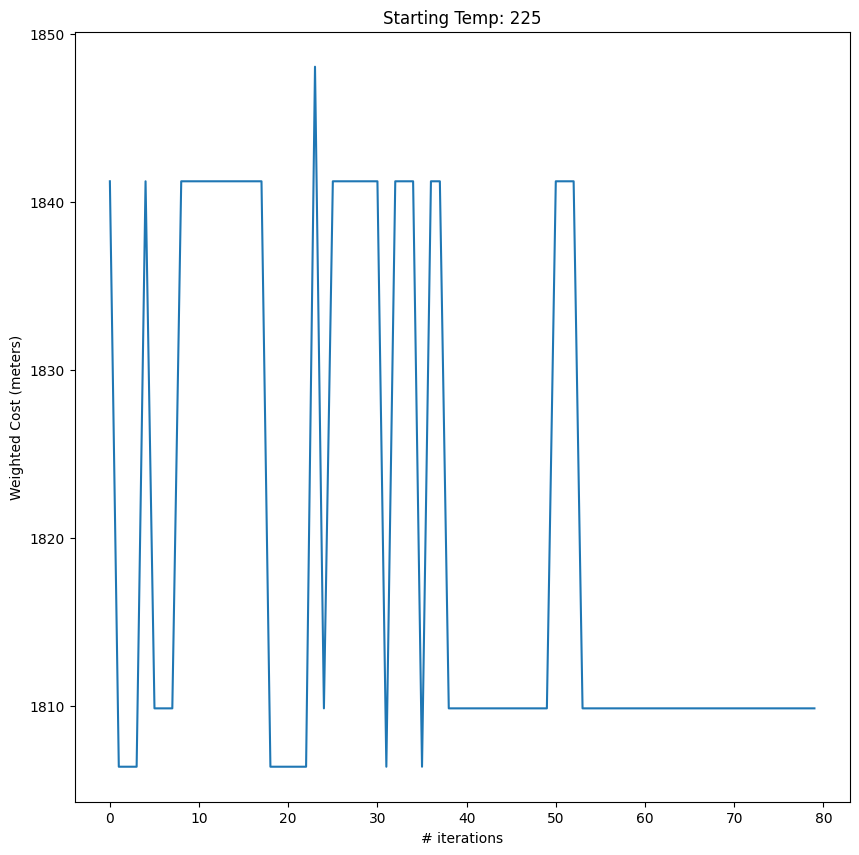

In [27]:
fig, axs = plt.subplots(1, 1)
fig.set_figheight(10)
fig.set_figwidth(10)
axs.plot(states1)
axs.title.set_text("Starting Temp: 225")
axs.set(xlabel='# iterations', ylabel="Weighted Cost (meters)")